# S&P 500 — Backtest (Experimental)

This notebook is an independent experiment that evaluates how signals from the prediction model could be used in simple investment strategies.
It reads the CSV exports produced by `sp500_model.ipynb` and simulates basic strategies with realistic touches (signal thresholding, position sizing, volatility filter, transaction costs).

This is not an investment system; the purpose is to illustrate the difference between predictive accuracy and economic performance.


## 0. Imports and data loading

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['axes.grid'] = True

df = pd.read_csv("data/df_prices.csv", index_col=0, parse_dates=True)
pred_df = pd.read_csv("data/pred_prices_test.csv", index_col=0, parse_dates=True)

dates_test = pred_df.index

sig = pd.DataFrame(index=dates_test)
sig["price_t"] = df.loc[dates_test, "AdjClose"]
sig["ret_mkt"] = sig["price_t"].pct_change()

sig["pred_ret"] = (pred_df["Pred_XGB"] / sig["price_t"]) - 1.0

display(sig.head())

,price_t,ret_mkt,pred_ret
Date,,,
2023-08-18,4369.709961,NaN,0.001686
2023-08-21,4399.770020,0.006879,-0.000930
2023-08-22,4387.549805,-0.002777,-0.001362
2023-08-23,4436.009766,0.011045,-0.004379
2023-08-24,4376.310059,-0.013458,-0.002849


## 1. Strategy parameters and volatility filter

In [3]:
# Parameters
COST   = 0.001
THRESH = 0.0005
SCALE  = 0.01
VIX_Q  = 0.6

vix_threshold = df["VIX"].quantile(VIX_Q) if "VIX" in df.columns else None
sig["vix_ok"] = (df.loc[dates_test, "VIX"] < vix_threshold).astype(int) if vix_threshold is not None else 1

## 2. Strategies and equity curves

In [4]:
# Strategy A: binary long when signal is strong and volatility filter passes
pos_A = ((sig["pred_ret"] > THRESH) & (sig["vix_ok"] == 1)).astype(float)

# Strategy B: proportional sizing to signal strength, filtered by volatility
pos_B = (sig["pred_ret"] / SCALE).clip(-1, 1)
pos_B = np.where(sig["vix_ok"] == 1, pos_B, 0.0)
pos_B = pd.Series(pos_B, index=sig.index)

def equity_curve(mkt_ret, position, cost=COST):
    position = position.fillna(0.0)
    turnover = position.diff().abs().fillna(0.0)
    strat_ret = position.shift(1) * mkt_ret - cost * turnover
    equity = (1 + strat_ret.fillna(0.0)).cumprod()
    return equity, strat_ret, turnover

eq_mkt = (1 + sig["ret_mkt"].fillna(0.0)).cumprod()
eq_A, ret_A, turn_A = equity_curve(sig["ret_mkt"], pos_A, cost=COST)
eq_B, ret_B, turn_B = equity_curve(sig["ret_mkt"], pos_B, cost=COST)

## 3. Metrics and chart

,name,CAGR%,Sharpe,MaxDD%,Turnover%/yr
0,Buy&Hold,22.531,1.372,-18.902,0.000
1,A (threshold),1.521,0.441,-2.989,1938.462
2,B (sizing),-10.126,-1.776,-20.613,5497.592


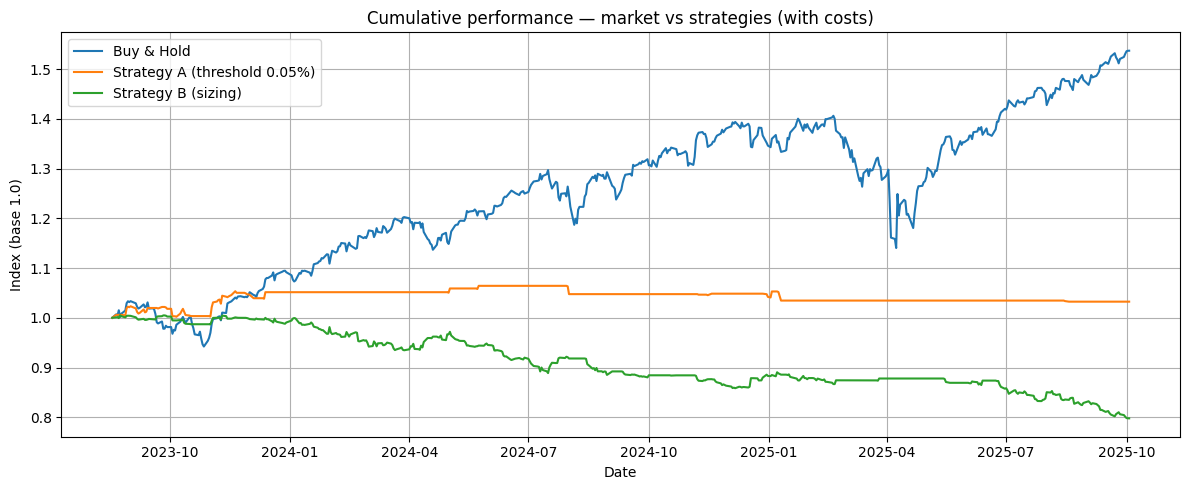

In [5]:
def metrics(equity, ret_series, name, turnover_series=None):
    n_days = ret_series.dropna().shape[0]
    if n_days == 0:
        return {"name": name, "CAGR%": np.nan, "Sharpe": np.nan, "MaxDD%": np.nan, "Turnover%/yr": np.nan}
    cagr = equity.iloc[-1] ** (252 / n_days) - 1.0
    sharpe = (ret_series.mean() / (ret_series.std() + 1e-12)) * np.sqrt(252)
    roll_max = equity.cummax()
    maxdd = (equity / roll_max - 1.0).min()
    turnover_yr = (turnover_series.sum() * (252 / n_days) * 100) if turnover_series is not None else 0.0
    return {"name": name, "CAGR%": 100*cagr, "Sharpe": sharpe, "MaxDD%": 100*maxdd, "Turnover%/yr": turnover_yr}

mtx = pd.DataFrame([
    metrics(eq_mkt, sig["ret_mkt"], "Buy&Hold"),
    metrics(eq_A,  ret_A,           "A (threshold)",  turn_A),
    metrics(eq_B,  ret_B,           "B (sizing)",     turn_B),
]).round(3)
display(mtx)

plt.figure(figsize=(12,5))
plt.plot(eq_mkt.index, eq_mkt, label="Buy & Hold")
plt.plot(eq_A.index,   eq_A,   label=f"Strategy A (threshold {THRESH*100:.2f}%)")
plt.plot(eq_B.index,   eq_B,   label=f"Strategy B (sizing)")
plt.title("Cumulative performance — market vs strategies (with costs)")
plt.xlabel("Date"); plt.ylabel("Index (base 1.0)")
plt.legend(); plt.tight_layout(); plt.show()
